In [2]:
import sctour as sct
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint
import scvi
import torch.nn as nn
import torch.optim as optim
from scvi.distributions import NegativeBinomial

ModuleNotFoundError: No module named 'sctour'

In [3]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scCFM/data/eb/processed/eb_phate.h5ad")

NameError: name 'sc' is not defined

In [4]:
adata.X = np.around(adata.layers["X_norm"])

NameError: name 'np' is not defined

In [5]:
tnode = sct.train.Trainer(adata, 
                          loss_mode='nb', 
                          alpha_recon_lec=0.5, 
                          alpha_recon_lode=0.5, 
                          n_latent = 10, 
                          n_ode_hidden = 64
                         )
tnode.train()

NameError: name 'sct' is not defined

In [5]:
adata.obs['ptime'] = tnode.get_time()

In [6]:
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.5, alpha_predz=0.5)
adata.obsm['X_TNODE'] = zs
adata.obsm['X_VF'] = tnode.get_vector_field(adata.obs['ptime'].values, adata.obsm['X_TNODE'])

In [7]:
adata = adata[np.argsort(adata.obs['ptime'].values), :]
sc.pp.neighbors(adata, use_rep='X_TNODE', n_neighbors=30)
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the 

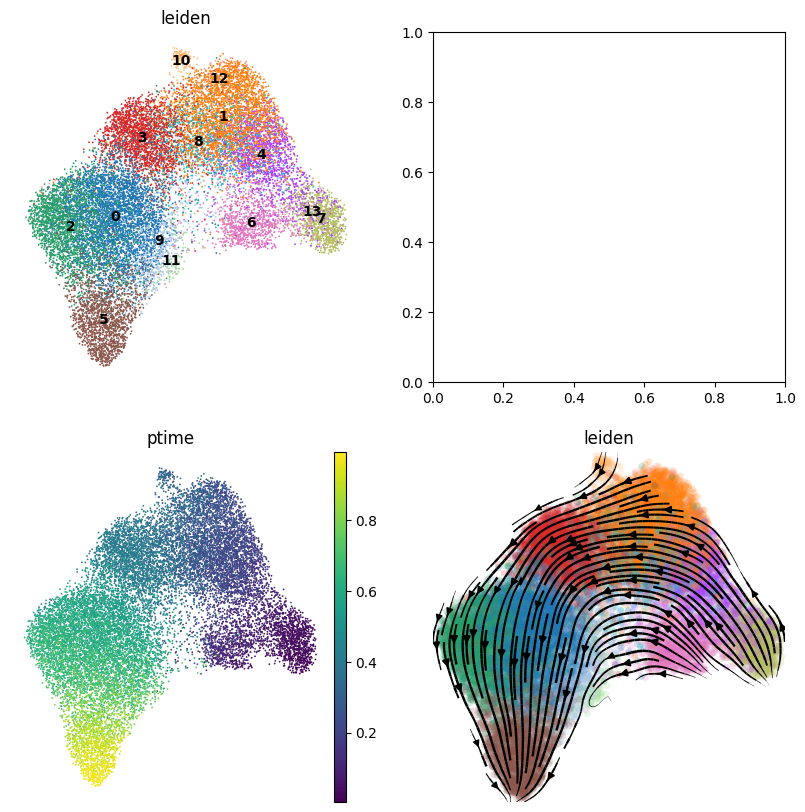

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
sc.pl.umap(adata, color='leiden', ax=axs[0, 0], legend_loc='on data', show=False, frameon=False)
sc.pl.umap(adata, color='ptime', ax=axs[1, 0], show=False, frameon=False)
sct.vf.plot_vector_field(adata, zs_key='X_TNODE', vf_key='X_VF', use_rep_neigh='X_TNODE', color='leiden', show=False, ax=axs[1, 1], legend_loc='none', frameon=False, size=100, alpha=0.2)
plt.show()

/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


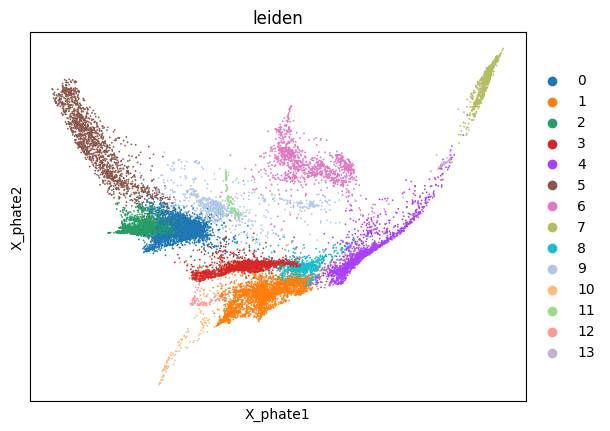

In [9]:
sc.pl.embedding(adata, basis="X_phate", color="leiden")

**Learn library size regression**

In [10]:
latents_tensor = torch.tensor(adata.obsm['X_TNODE'])
library_size = torch.tensor(adata.X.sum(1))

In [11]:
# Define the regression model
class LibrarySizeRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LibrarySizeRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Instantiate the model
input_size = 10  # Adjust according to your latent representation size
hidden_size = 64  # You can adjust this as well
output_size = 1  # Output size is 1 for regression
model = LibrarySizeRegressor(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100000

for epoch in range(num_epochs):
    # Forward pass
    predicted_library_size = model(latents_tensor)

    # Compute the loss
    loss = criterion(torch.exp(predicted_library_size), library_size)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/100000], Loss: 303774.1562
Epoch [200/100000], Loss: 127447.9922
Epoch [300/100000], Loss: 17126.0293
Epoch [400/100000], Loss: 8427.5635
Epoch [500/100000], Loss: 7157.1650
Epoch [600/100000], Loss: 6788.3921
Epoch [700/100000], Loss: 6603.4399
Epoch [800/100000], Loss: 6482.4443
Epoch [900/100000], Loss: 6396.3433
Epoch [1000/100000], Loss: 6331.0356
Epoch [1100/100000], Loss: 6280.4155
Epoch [1200/100000], Loss: 6238.4131
Epoch [1300/100000], Loss: 6201.3110
Epoch [1400/100000], Loss: 6170.1260
Epoch [1500/100000], Loss: 6143.8838
Epoch [1600/100000], Loss: 6120.9653
Epoch [1700/100000], Loss: 6100.7896
Epoch [1800/100000], Loss: 6082.0918
Epoch [1900/100000], Loss: 6063.8579
Epoch [2000/100000], Loss: 6046.6670
Epoch [2100/100000], Loss: 6031.7207
Epoch [2200/100000], Loss: 6017.8271
Epoch [2300/100000], Loss: 6004.6777
Epoch [2400/100000], Loss: 5992.4409
Epoch [2500/100000], Loss: 5980.4307
Epoch [2600/100000], Loss: 5967.8193
Epoch [2700/100000], Loss: 5955.1064
Epoch

**Try predictions**

In [12]:
adata_t0 = adata[:100, :]

In [13]:
adata_t0.obs

,sample_labels,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,leiden,dpt_pseudotime,1d-phate,1d-phate-normalized,experimental_time,ptime
AACTCTTGTTATCC-1_Day 00-03,Day 00-03,2436,7.798523,9403.0,9.148890,29.777731,44.166755,56.418164,72.072743,7,0.029505,0.056244,2.690106,0.0,0.004056
TCTTGATGGGTTTG-1_Day 00-03,Day 00-03,2447,7.803027,8855.0,9.088850,29.497459,43.410503,55.200452,70.536420,7,0.039338,0.057564,2.752556,0.0,0.005570
CTACAACTCCAGTA-1_Day 00-03,Day 00-03,2255,7.721349,8316.0,9.026057,30.796056,44.853295,57.227032,72.619048,7,0.026828,0.055623,2.660711,0.0,0.005701
GATATCCTCTGAAC-1_Day 00-03,Day 00-03,2503,7.825645,9393.0,9.147826,28.936442,42.765889,54.987757,70.424784,7,0.006777,0.058764,2.809311,0.0,0.006115
AATCTCTGTAACCG-1_Day 00-03,Day 00-03,2615,7.869402,9249.0,9.132379,26.835334,39.820521,52.048870,68.191156,7,0.055346,0.055689,2.663810,0.0,0.006698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTTAACACCTGGAT-1_Day 00-03,Day 00-03,2561,7.848543,9567.0,9.166180,30.396153,44.120414,56.078185,70.377339,7,0.022537,0.057511,2.750052,0.0,0.014747
CTCTAAACACAGTC-1_Day 00-03,Day 00-03,2640,7.878913,9868.0,9.197154,26.813944,40.575598,52.908391,69.233887,7,0.090384,0.057592,2.753897,0.0,0.014775
AGCGCCGAATCTTC-1_Day 00-03,Day 00-03,1997,7.599902,5933.0,8.688454,27.186921,39.204450,51.845609,69.593797,7,0.020047,0.057056,2.728500,0.0,0.014832
CATACTACTCGCAA-1_Day 00-03,Day 00-03,2398,7.782807,9013.0,9.106534,29.080217,43.082215,55.142572,70.886497,7,0.006476,0.056463,2.700450,0.0,0.014882


In [14]:
zs_adata = sc.AnnData(X=pred_zs, obs=adata.obs)

In [15]:
sc.tl.pca(zs_adata)
sc.pp.neighbors(zs_adata)
sc.tl.umap(zs_adata)

Predict transcription with NODE

In [16]:
X_t0 = torch.tensor(adata_t0.obsm["X_TNODE"])

In [17]:
t_steps = torch.linspace(0,1,101)
t_steps

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900, 1.0000])

In [18]:
X_traj = odeint(tnode.model.lode_func, X_t0.cpu(), t_steps).view(-1, 10)

In [19]:
times = np.around(t_steps.view(-1,1).repeat((1,100)).view(-1), 2)
times_df = pd.DataFrame(times)
times_df.columns = ["time"]

In [20]:
adata_generated = sc.AnnData(X=X_traj.detach().cpu().numpy(), obs=times_df)
# adata_generated = adata_generated[adata_generated.obs.time.isin([0.00, 0.20, 0.40, 0.60, 0.80, 1.00])]

/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [21]:
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

In [1]:
sc.pl.pca(adata_generated, color="time", annotate_var_explained=True)

NameError: name 'sc' is not defined

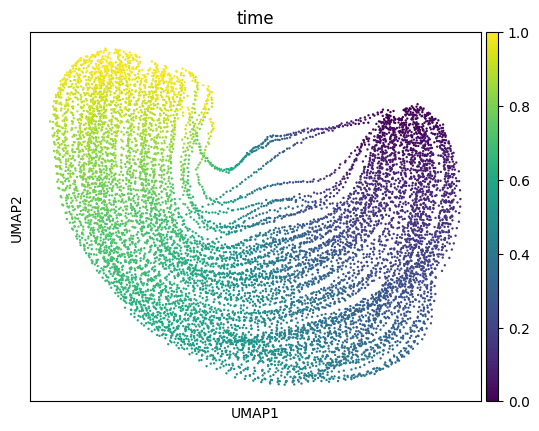

In [23]:
sc.pl.umap(adata_generated, color="time")

In [24]:
# torch.save(tnode, "/lustre/groups/ml01/workspace/alessandro.palma/scCFM/rebuttals/scTour/checkpoints.pt")

In [25]:
X_traj_decoded = tnode.model.decoder(X_traj.cuda())

In [26]:
library_size_traj_decoded = torch.exp(model(X_traj)).cuda()

In [27]:
distr = NegativeBinomial(mu=X_traj_decoded*library_size_traj_decoded, theta=torch.exp(tnode.model.decoder.disp))
samples = distr.sample()

In [28]:
adata_generated_counts = sc.AnnData(X=samples.detach().cpu().numpy(), obs=adata_generated.obs)
sc.tl.pca(adata_generated_counts)
sc.pp.neighbors(adata_generated_counts)
sc.tl.umap(adata_generated_counts)

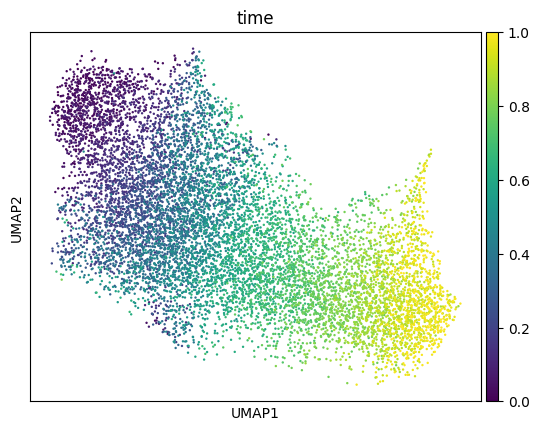

In [29]:
sc.pl.umap(adata_generated_counts, color="time")

**Stitch to real dataset**

In [30]:
dataset_type = ["real" for _ in range(len(adata.X.A))] + ["generated" for _ in range(len(samples))]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_types"]
adata_generated_real_counts = sc.AnnData(X=np.concatenate([adata.X.A, 
                                                      samples.detach().cpu().numpy()], axis=0), obs=dataset_type)
sc.tl.pca(adata_generated_real_counts)
sc.pp.neighbors(adata_generated_real_counts)
sc.tl.umap(adata_generated_real_counts)

/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


... storing 'dataset_types' as categorical
/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


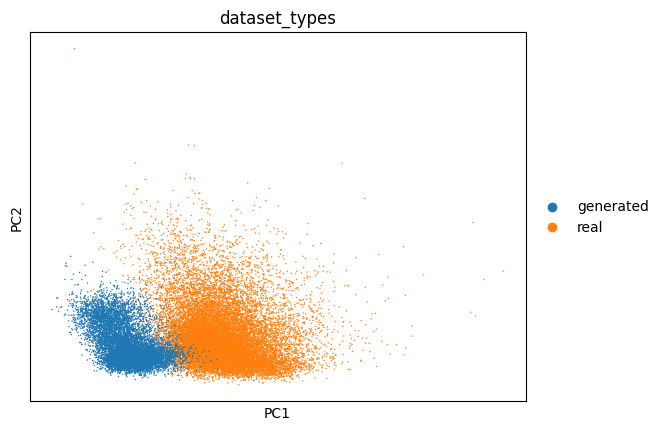

In [31]:
sc.pl.pca(adata_generated_real_counts, color="dataset_types")

/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/velocity_benchmarks/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


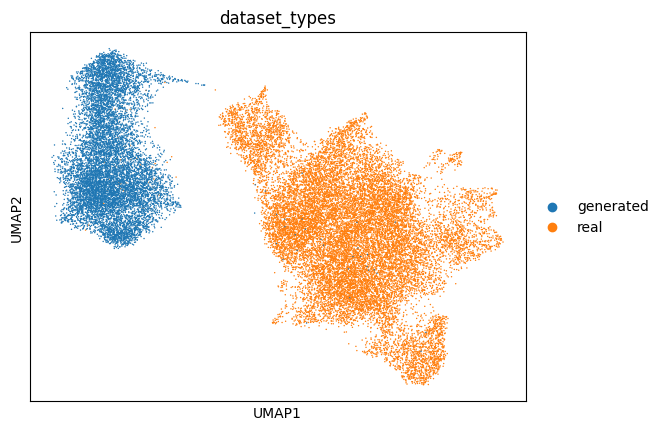

In [32]:
sc.pl.umap(adata_generated_real_counts, color="dataset_types")

In [34]:
adata_generated_counts.write_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scCFM/rebuttals/scTour/generated_counts.h5ad")

In [35]:
adata_generated_real_counts.write_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scCFM/rebuttals/scTour/generated_real_counts.h5ad")